In [1]:
%%time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from torchvision import transforms
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
from transformers import SamModel, SamProcessor
from torch import nn
from scipy.ndimage import label, find_objects
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

# DataSet
class SplashDataSet_train_val_0501(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "images")
        self.masks_dir = os.path.join(self.root_dir, "annotations")
        # get filenames
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        assert len(self.images_list) == len(self.masks_list), "Number of images and annotations should be the same."

        # transform image to 1024*1024
        self.transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),  # This will scale pixel values to [0, 1]
        ])
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # get image and annotation file
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_list[idx])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        
        return image, mask

    def get_time_category(self, filename):
        # my filenames' format is 2024-04-09-03-00-11.png
        time_str = filename.split('-')[3:5]
        time_obj = datetime.strptime('-'.join(time_str), '%H-%M')
        hour = time_obj.hour
        if hour < 8:
            return 'morning'
        elif 8 <= hour <= 16:
            return 'day'
        else:
            return 'evening'

def focal_loss(inputs, targets, alpha=0.25, gamma=2.0, reduction='mean'):
    #print("inputs size = ", inputs.size())
    # inputs size =  torch.Size([1, 2, 1024, 1024])
    #print("targets size = ", targets.size())
    # targets size =  torch.Size([1, 1024, 1024])
    BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    F_loss = at * (1 - pt)**gamma * BCE_loss

    if reduction == 'mean':
        return torch.mean(F_loss), (1 - pt)**gamma
    elif reduction == 'sum':
        return torch.sum(F_loss)
    else:
        return F_loss

# criterion
def criterion(outputs, labels):
    return torch.nn.functional.cross_entropy(outputs, labels.squeeze(1).long())

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #print("student_outputs size = ", student_outputs.size())
    # print("student_outputs = ", student_outputs["out"])
    #print("teacher_outputs size = ", teacher_outputs.size())
    # print("teacher_outputs = ", teacher_outputs)
    #print("ground truth size = ", labels.size())
    
    # Calculate Cross Entropy
    # original_loss = torch.nn.functional.cross_entropy(student_outputs, labels.squeeze(1).long())

    # Calculate Focal Loss , not sure about alpha and gamme
    #original_loss = focal_loss(student_outputs[:,1,:,:], labels.squeeze(1).float(), alpha=0.25, gamma=2.0)
    alpha=0.25
    gamma=2.0
    targets = labels.squeeze(1).float()
    BCE_loss = F.binary_cross_entropy_with_logits(student_outputs[:,1,:,:], targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    modulating_number = torch.mean((1 - pt)**gamma)
    F_loss = at * modulating_number * BCE_loss
    #print("modulating_number = ", modulating_number)
    # mean
    original_loss = torch.mean(F_loss)
    #print("original loss = ", original_loss)

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs[0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))
    #print("distillation loss = ", distillation_loss)
    
    # total loss
    total_loss = modulating_number*((1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss)
    return total_loss

# evaluate
def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)

            outputs = model(image)

            loss = criterion(outputs['out'], mask)

            # Calculate Focal Loss , not sure about alpha and gamme
            #print("outputs size = ", outputs['out'].size())
            #print("mask size = ", mask.size())
            # outputs['out'] size =  torch.Size([1, 2, 1024, 1024])
            # mask size =  torch.Size([1, 1, 1024, 1024])
            #loss = focal_loss(outputs['out'][:,1:2,:,:], mask.float())
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Average validation loss: {avg_loss}")
    return avg_loss

# train every epoch
def train_one_epoch(student_model, teacher_model, teacher_image_processor, data_loader, teacher_ratio, temperature, optimizer, device, pbar):
    student_model.to(device)
    student_model.train()
    teacher_model.to(device)
    teacher_model.eval()
    training_loss = []
    for idx, (image, mask) in enumerate(data_loader):
        #bbox = [[[get_bounding_box(np.array(mask))]]]
        bbox, point = get_bounding_box_and_center(np.array(mask))
        #print("[train_one_epoch] bbox = ", bbox)
        #print("[train_one_epoch] point = ", point)
        image, mask = image.to(device), mask.to(device)
        # image size = torch.Size([1, 3, 1024, 1024])start_step
        # mask size = torch.Size([1, 1, 1024, 1024])

        optimizer.zero_grad()
        # output for student model ----------------------------------------------------------
        student_outputs = student_model(image)
        # outputs size = torch.Size([1, 2, 1024, 1024])
        # -----------------------------------------------------------------------------------
        # output for teacher model ----------------------------------------------------------
        # Retrieve the image embeddings
        # processor
        teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        teacher_image_embeddings = teacher_model.get_image_embeddings(teacher_inputs["pixel_values"])
        
        # 送到processor計算遮罩
        if bbox is None:
            teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        else:
            teacher_inputs = teacher_image_processor(image, input_points=[[[point]]], input_boxes=[[[bbox]]], return_tensors="pt", do_rescale=False).to(device)

        teacher_inputs.pop("pixel_values", None)
        teacher_inputs.update({"image_embeddings": teacher_image_embeddings})

        teacher_outputs = teacher_model(**teacher_inputs)
        teacher_masks, teacher_output = teacher_image_processor.image_processor.post_process_masks(teacher_outputs.pred_masks.cpu(), teacher_inputs["original_sizes"].cpu(), teacher_inputs["reshaped_input_sizes"].cpu())  
        # -----------------------------------------------------------------------------------
        #loss = criterion(student_outputs, mask)
        loss = KD_criterion(student_outputs['out'], teacher_output[0], mask, teacher_ratio, temperature)
        loss.backward()
        optimizer.step()
        """
        [train_one_epoch] image size =  torch.Size([1, 3, 1024, 1024])
        [train_one_epoch]0 mask size =  torch.Size([1, 1, 1024, 1024])
        [train_one_epoch]0 outputs size =  torch.Size([1, 2, 128, 128])
        [train_one_epoch]1 outputs size =  torch.Size([1, 2, 1024, 1024])
        """
        training_loss.append(loss.item())
        pbar.update(idx + 1, values=[("loss", loss.item())])
    return np.mean(np.array(training_loss))

# train
def train(model, teacher_model, teacher_image_processor, train_loader, val_loader, train_size, save_model, teacher_ratio=0.7, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, ":",torch.cuda.get_device_name(0))

    train_losses   = []
    val_losses     = []
    epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    n_batch = len(train_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch, stateful_metrics=None)
    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_data_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則新增它
    #weights_dir = os.path.join(os.getcwd(),"weights")
    weights_dir = os.path.join(os.getcwd(), f"weights/weights_KD_segformer_0604/weights_KD_segformer_0604_{int(teacher_ratio*100)}")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss = train_one_epoch(model, teacher_model, teacher_image_processor, train_loader, teacher_ratio, temperature, optimizer, device, pbar)
        train_losses.append(train_loss)

        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            pbar.update(n_batch, values=[('val_loss', val_loss)])

            if val_loss < best_val_loss and save_model:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_pathname)
                print(f"Saved model weights to '{model_pathname}'.")
    print(f"Train loss: {np.mean(train_losses)}, Validation loss: {np.mean(val_losses)}" if val_loader is not None else f"Train loss: {np.mean(train_losses)}")
    return {'loss':train_losses, 'val_loss':val_losses}

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def get_bounding_box_and_center(ground_truth_map):
    #print("[get_bounding_box_and_center]")
    ground_truth_map = ground_truth_map[0, 0, :, :]
    if np.any(ground_truth_map > 0):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        # Identify the largest connected component (largest mask area)
        labeled_array, num_features = label(ground_truth_map > 0)
        if num_features > 0:
            # Find the largest component
            max_label = 1 + np.argmax([np.sum(labeled_array == i) for i in range(1, num_features+1)])
            # Get the slice for the largest component
            largest_component_slice = find_objects(labeled_array == max_label)[0]
            yc, xc = largest_component_slice
            center_x = xc.start + (xc.stop - xc.start) // 2
            center_y = yc.start + (yc.stop - yc.start) // 2
            center_point = (center_x, center_y)
        else:
            center_point = ((x_min + x_max) // 2, (y_min + y_max) // 2)
    else:
        bbox = None
        center_point = None
    return bbox, center_point

class MySegFormer_0604(nn.Module):
    def __init__(self,num_classes,backbone="b0",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()}
                                                         , ignore_mismatched_sizes=True)
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}
        # 在conda 環境裡huggingface包好的Segformer有改(modeling_segformer.py)

# Student Model: Segformer 0601
backbone = "b0"
num_classes = 2
model_segformer = MySegFormer_0604(num_classes, backbone)

# Teacher Model: Segment Anything Model
model_sam = SamModel.from_pretrained("facebook/sam-vit-huge")
processor_sam = SamProcessor.from_pretrained("facebook/sam-vit-huge")

train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
#train_sizes = [300]
# 放所有 fold 的 平均、標準差
mean_val_losses = []
std_val_losses = []
root_dir = select_folder()

#root_dir = "C:/Users/user/Desktop/NAS_data/鱸魚/高雄黃明和/train_0418"
#print(root_dir)

# My DataSet, return image, mask
train_val_dataset = SplashDataSet_train_val_0501(root_dir=root_dir)
labels = [train_val_dataset.get_time_category(filename) for filename in train_val_dataset.images_list]
#print("indices 1= ", indices)
#print("label size = ", label.size())
#print("label = ", len(labels))
#print("len(train_val_dataset = )", len(train_val_dataset))
for train_size in train_sizes:
    # 在前一個大小的資料袋中擴增資料(train+validation)
    indices = np.arange(len(train_val_dataset))
    indices = indices[:train_size]
    # print("indices = ", indices)
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_losses = []  # 放每個 fold 的 validation loss
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, [labels[i] for i in indices])):
        print(f'FOLD {fold+1}')
        print('--------------------------------')
        train_idx = indices[train_idx]
        val_idx = indices[val_idx]
        """
        for i in indices:
            print("i = ", i)
            print("labels[i] = ", labels[i])
        print("----")
        """
        
        train_subset = Subset(train_val_dataset, train_idx)
        val_subset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)
        # train
        # Please replace Diatillation_Loss_Ratio to the teacher_ratio from 0 ~ 1 
        teacher_ratio = 0.6
        temperature = 5
        lc = train(model_segformer, model_sam, processor_sam, train_loader, val_loader, train_size, True, teacher_ratio, temperature)

        val_loss = lc['val_loss']
        val_losses.append(val_loss)
    mean_val_losses.append(np.mean(val_losses))
    std_val_losses.append(np.std(val_losses))


c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


FOLD 1
--------------------------------
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10


c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 [==============================] - 7s 786ms/step - loss: 0.0107
Average validation loss: 0.6699634790420532
4/4 [==============================] - 7s 799ms/step - loss: 0.0107 - val_loss: 0.6700
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_60\segformer_data_size_5.pth'.
Epoch 2/10
4/4 [==============================] - 10s 774ms/step - loss: 0.0068 - val_loss: 0.6700
Average validation loss: 0.5000962615013123
4/4 [==============================] - 10s 787ms/step - loss: 0.0068 - val_loss: 0.5850
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_60\segformer_data_size_5.pth'.
Epoch 3/10
4/4 [==============================] - 13s 795ms/step - loss: 0.0048 - val_loss: 0.5850
Average validation loss: 0.46222320199012756
4/4 [==============================] - 13s 812ms/step - loss: 0.0048 - val_l

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


8/8 [==============================] - 6s 746ms/step - loss: 6.3778e-07
Average validation loss: 0.00619105901569128
8/8 [==============================] - 6s 757ms/step - loss: 6.3778e-07 - val_loss: 0.0062
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_60\segformer_data_size_10.pth'.
Epoch 2/10
8/8 [==============================] - 12s 689ms/step - loss: 6.2191e-07 - val_loss: 0.0062
Average validation loss: 0.004358902107924223
8/8 [==============================] - 12s 701ms/step - loss: 6.2191e-07 - val_loss: 0.0053
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_60\segformer_data_size_10.pth'.
Epoch 3/10
8/8 [==============================] - 17s 694ms/step - loss: 6.1375e-07 - val_loss: 0.0053
Average validation loss: 0.007983569288626313
8/8 [==============================] - 17s 709ms/s

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


12/12 [==============================] - 8s 681ms/step - loss: 1.7730e-06
Average validation loss: 0.03266241657547653
12/12 [==============================] - 8s 691ms/step - loss: 1.7730e-06 - val_loss: 0.0327
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_60\segformer_data_size_15.pth'.
Epoch 2/10
12/12 [==============================] - 17s 698ms/step - loss: 1.7746e-06 - val_loss: 0.0327
Average validation loss: 0.03036473000732561
12/12 [==============================] - 17s 710ms/step - loss: 1.7746e-06 - val_loss: 0.0315
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_60\segformer_data_size_15.pth'.
Epoch 3/10
12/12 [==============================] - 25s 688ms/step - loss: 1.8479e-06 - val_loss: 0.0315
Average validation loss: 0.02979475030830751
12/12 [==============================] - 2

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


16/16 [==============================] - 11s 693ms/step - loss: 1.1062e-06
Average validation loss: 0.06926828436553478
16/16 [==============================] - 11s 704ms/step - loss: 1.1062e-06 - val_loss: 0.0693
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_60\segformer_data_size_20.pth'.
Epoch 2/10
16/16 [==============================] - 22s 690ms/step - loss: 1.0429e-06 - val_loss: 0.0693
Average validation loss: 0.048584155199932866
16/16 [==============================] - 22s 700ms/step - loss: 1.0429e-06 - val_loss: 0.0589
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_60\segformer_data_size_20.pth'.
Epoch 3/10
16/16 [==============================] - 34s 704ms/step - loss: 9.9459e-07 - val_loss: 0.0589
Average validation loss: 0.04319727933034301
16/16 [==============================] 

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


20/20 [==============================] - 14s 707ms/step - loss: 5.4175e-07
Average validation loss: 0.0625679574906826
20/20 [==============================] - 14s 718ms/step - loss: 5.4175e-07 - val_loss: 0.0626
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_60\segformer_data_size_25.pth'.
Epoch 2/10
20/20 [==============================] - 28s 700ms/step - loss: 5.2036e-07 - val_loss: 0.0626
Average validation loss: 0.06615538764744996
20/20 [==============================] - 29s 711ms/step - loss: 5.2036e-07 - val_loss: 0.0644
Epoch 3/10
20/20 [==============================] - 43s 697ms/step - loss: 5.0041e-07 - val_loss: 0.0644
Average validation loss: 0.16231571584939958
20/20 [==============================] - 43s 707ms/step - loss: 5.0041e-07 - val_loss: 0.0970
Epoch 4/10
20/20 [==============================] - 57s 709ms/step - loss: 4.8895e-07 - val_loss: 0.0970
Average validation

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


24/24 [==============================] - 17s 707ms/step - loss: 7.5548e-07
Average validation loss: 0.06639868952333927
24/24 [==============================] - 17s 716ms/step - loss: 7.5548e-07 - val_loss: 0.0664
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_60\segformer_data_size_30.pth'.
Epoch 2/10
24/24 [==============================] - 34s 696ms/step - loss: 6.8678e-07 - val_loss: 0.0664
Average validation loss: 0.06710314626495044
24/24 [==============================] - 34s 706ms/step - loss: 6.8678e-07 - val_loss: 0.0668
Epoch 3/10
24/24 [==============================] - 51s 701ms/step - loss: 6.1683e-07 - val_loss: 0.0668
Average validation loss: 0.07180236093699932
24/24 [==============================] - 51s 711ms/step - loss: 6.1683e-07 - val_loss: 0.0684
Epoch 4/10
24/24 [==============================] - 68s 692ms/step - loss: 5.8301e-07 - val_loss: 0.0684
Average validatio

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


40/40 [==============================] - 28s 695ms/step - loss: 1.3529e-06
Average validation loss: 0.16832278221845626
40/40 [==============================] - 28s 706ms/step - loss: 1.3529e-06 - val_loss: 0.1683
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_60\segformer_data_size_50.pth'.
Epoch 2/10
40/40 [==============================] - 56s 701ms/step - loss: 1.4061e-06 - val_loss: 0.1683
Average validation loss: 0.10024299621582031
40/40 [==============================] - 57s 711ms/step - loss: 1.4061e-06 - val_loss: 0.1343
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_60\segformer_data_size_50.pth'.
Epoch 3/10
40/40 [==============================] - 84s 692ms/step - loss: 1.3088e-06 - val_loss: 0.1343
Average validation loss: 0.11017240062355996
40/40 [==============================] -

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


48/48 [==============================] - 34s 706ms/step - loss: 7.4517e-07
Average validation loss: 0.0774223607343932
48/48 [==============================] - 34s 717ms/step - loss: 7.4517e-07 - val_loss: 0.0774
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_60\segformer_data_size_60.pth'.
Epoch 2/10
48/48 [==============================] - 68s 701ms/step - loss: 6.0765e-07 - val_loss: 0.0774
Average validation loss: 0.0525648663751781
48/48 [==============================] - 69s 711ms/step - loss: 6.0765e-07 - val_loss: 0.0650
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_60\segformer_data_size_60.pth'.
Epoch 3/10
48/48 [==============================] - 103s 704ms/step - loss: 5.3983e-07 - val_loss: 0.0650
Average validation loss: 0.06735105556435883
48/48 [==============================] - 

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


56/56 [==============================] - 40s 711ms/step - loss: 1.3488e-06
Average validation loss: 0.0782178164393242
56/56 [==============================] - 40s 722ms/step - loss: 1.3488e-06 - val_loss: 0.0782
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_60\segformer_data_size_70.pth'.
Epoch 2/10
56/56 [==============================] - 80s 711ms/step - loss: 8.5640e-07 - val_loss: 0.0782
Average validation loss: 0.056097517987447124
56/56 [==============================] - 81s 722ms/step - loss: 8.5640e-07 - val_loss: 0.0672
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_60\segformer_data_size_70.pth'.
Epoch 3/10
56/56 [==============================] - 120s 704ms/step - loss: 6.5739e-07 - val_loss: 0.0672
Average validation loss: 0.06033155667994704
56/56 [==============================] 

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


64/64 [==============================] - 50s 784ms/step - loss: 4.2081e-07
Average validation loss: 0.047272617026465014
64/64 [==============================] - 51s 795ms/step - loss: 4.2081e-07 - val_loss: 0.0473
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_60\segformer_data_size_80.pth'.
Epoch 2/10
64/64 [==============================] - 101s 781ms/step - loss: 3.1090e-07 - val_loss: 0.0473
Average validation loss: 0.04334368830313906
64/64 [==============================] - 102s 793ms/step - loss: 3.1090e-07 - val_loss: 0.0453
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_60\segformer_data_size_80.pth'.
Epoch 3/10
64/64 [==============================] - 152s 780ms/step - loss: 2.6426e-07 - val_loss: 0.0453
Average validation loss: 0.04130278091179207
64/64 [=============================

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


72/72 [==============================] - 57s 792ms/step - loss: 4.6624e-07
Average validation loss: 0.06403479507813852
72/72 [==============================] - 58s 803ms/step - loss: 4.6624e-07 - val_loss: 0.0640
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_60\segformer_data_size_90.pth'.
Epoch 2/10
72/72 [==============================] - 115s 793ms/step - loss: 3.7997e-07 - val_loss: 0.0640
Average validation loss: 0.06165860272530052
72/72 [==============================] - 116s 804ms/step - loss: 3.7997e-07 - val_loss: 0.0628
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_60\segformer_data_size_90.pth'.
Epoch 3/10
72/72 [==============================] - 173s 792ms/step - loss: 3.0474e-07 - val_loss: 0.0628
Average validation loss: 0.044702746336244874
72/72 [=============================

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


80/80 [==============================] - 56s 701ms/step - loss: 4.6820e-07
Average validation loss: 0.04461957486346364
80/80 [==============================] - 57s 711ms/step - loss: 4.6820e-07 - val_loss: 0.0446
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_60\segformer_data_size_100.pth'.
Epoch 2/10
80/80 [==============================] - 114s 713ms/step - loss: 3.2128e-07 - val_loss: 0.0446
Average validation loss: 0.04447676865383983
80/80 [==============================] - 115s 723ms/step - loss: 3.2128e-07 - val_loss: 0.0445
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_60\segformer_data_size_100.pth'.
Epoch 3/10
80/80 [==============================] - 171s 703ms/step - loss: 2.4576e-07 - val_loss: 0.0445
Average validation loss: 0.0457064594142139
80/80 [=============================

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


96/96 [==============================] - 68s 708ms/step - loss: 8.2582e-07
Average validation loss: 0.06578597769839689
96/96 [==============================] - 69s 717ms/step - loss: 8.2582e-07 - val_loss: 0.0658
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_60\segformer_data_size_120.pth'.
Epoch 2/10
96/96 [==============================] - 137s 709ms/step - loss: 6.7979e-07 - val_loss: 0.0658
Average validation loss: 0.0705882640904747
96/96 [==============================] - 138s 719ms/step - loss: 6.7979e-07 - val_loss: 0.0682
Epoch 3/10
96/96 [==============================] - 206s 709ms/step - loss: 5.2966e-07 - val_loss: 0.0682
Average validation loss: 0.06965852951786171
96/96 [==============================] - 207s 719ms/step - loss: 5.2966e-07 - val_loss: 0.0687
Epoch 4/10
96/96 [==============================] - 275s 706ms/step - loss: 4.4076e-07 - val_loss: 0.0687
Average vali

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


120/120 [==============================] - 85s 704ms/step - loss: 1.3417e-06
Average validation loss: 0.05825757843752702
120/120 [==============================] - 86s 714ms/step - loss: 1.3417e-06 - val_loss: 0.0583
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_60\segformer_data_size_150.pth'.
Epoch 2/10
120/120 [==============================] - 170s 701ms/step - loss: 1.2641e-06 - val_loss: 0.0583
Average validation loss: 0.06816654067176084
120/120 [==============================] - 171s 711ms/step - loss: 1.2641e-06 - val_loss: 0.0632
Epoch 3/10
120/120 [==============================] - 256s 705ms/step - loss: 1.2294e-06 - val_loss: 0.0632
Average validation loss: 0.056325828470289704
120/120 [==============================] - 257s 715ms/step - loss: 1.2294e-06 - val_loss: 0.0609
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_s

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


144/144 [==============================] - 101s 702ms/step - loss: 3.7064e-07
Average validation loss: 0.04570029132689039
144/144 [==============================] - 103s 712ms/step - loss: 3.7064e-07 - val_loss: 0.0457
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_60\segformer_data_size_180.pth'.
Epoch 2/10
144/144 [==============================] - 204s 703ms/step - loss: 2.6996e-07 - val_loss: 0.0457
Average validation loss: 0.057421283236989334
144/144 [==============================] - 205s 714ms/step - loss: 2.6996e-07 - val_loss: 0.0516
Epoch 3/10
144/144 [==============================] - 306s 699ms/step - loss: 2.2135e-07 - val_loss: 0.0516
Average validation loss: 0.043933065582273736
144/144 [==============================] - 307s 709ms/step - loss: 2.2135e-07 - val_loss: 0.0490
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_K

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


160/160 [==============================] - 114s 709ms/step - loss: 2.3960e-07
Average validation loss: 0.048740460558474294
160/160 [==============================] - 115s 719ms/step - loss: 2.3960e-07 - val_loss: 0.0487
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_60\segformer_data_size_200.pth'.
Epoch 2/10
160/160 [==============================] - 228s 703ms/step - loss: 1.7802e-07 - val_loss: 0.0487
Average validation loss: 0.036252242149203084
160/160 [==============================] - 229s 713ms/step - loss: 1.7802e-07 - val_loss: 0.0425
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_60\segformer_data_size_200.pth'.
Epoch 3/10
160/160 [==============================] - 342s 705ms/step - loss: 1.4553e-07 - val_loss: 0.0425
Average validation loss: 0.03858389577944763
160/160 [============

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


200/200 [==============================] - 143s 713ms/step - loss: 9.9142e-07
Average validation loss: 0.061911721248179674
200/200 [==============================] - 145s 723ms/step - loss: 9.9142e-07 - val_loss: 0.0619
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_60\segformer_data_size_250.pth'.
Epoch 2/10
200/200 [==============================] - 286s 705ms/step - loss: 6.7346e-07 - val_loss: 0.0619
Average validation loss: 0.052365585211664435
200/200 [==============================] - 288s 715ms/step - loss: 6.7346e-07 - val_loss: 0.0571
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_60\segformer_data_size_250.pth'.
Epoch 3/10
200/200 [==============================] - 430s 711ms/step - loss: 5.5659e-07 - val_loss: 0.0571
Average validation loss: 0.04790621405467391
200/200 [============

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


  1/240 [..............................] - ETA: 2:40 - loss: 4.6628e-08

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


240/240 [==============================] - 169s 704ms/step - loss: 3.3856e-07
Average validation loss: 0.06535190987827567
240/240 [==============================] - 171s 714ms/step - loss: 3.3856e-07 - val_loss: 0.0654
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_60\segformer_data_size_300.pth'.
Epoch 2/10
240/240 [==============================] - 340s 702ms/step - loss: 2.5133e-07 - val_loss: 0.0654
Average validation loss: 0.06557172491642026
240/240 [==============================] - 342s 712ms/step - loss: 2.5133e-07 - val_loss: 0.0655
Epoch 3/10
240/240 [==============================] - 512s 706ms/step - loss: 1.9964e-07 - val_loss: 0.0655
Average validation loss: 0.0623641526636978
240/240 [==============================] - 514s 716ms/step - loss: 1.9964e-07 - val_loss: 0.0644
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_s

train_size size =  18
mean_val_losses size =  18
std_val_losses size =  18
train_size =  [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
mean_val_losses =  [0.09731938620796426, 0.028718783753283787, 0.06620209746057905, 0.072531520271732, 0.07186881095450372, 0.06690090773006281, 0.08930573161598296, 0.05562380722025409, 0.055258546492883136, 0.04616437829885399, 0.041491791308055526, 0.04014414032764033, 0.09374940028535395, 0.04568237758986652, 0.04170141124337938, 0.03475052948322263, 0.045293130478705285, 0.041629434757497315]
std_val_losses =  [0.15690225207689196, 0.015002497757350361, 0.0321560245993081, 0.03175494827778532, 0.027566878237110005, 0.01839167540108409, 0.02237139725840191, 0.013008579160961329, 0.011639608782081725, 0.008498709113428527, 0.007942879380850757, 0.006499262398459626, 0.13299358735763855, 0.012269962722053593, 0.006714779527740514, 0.006984396172427369, 0.0083695976257705, 0.009914198047216811]


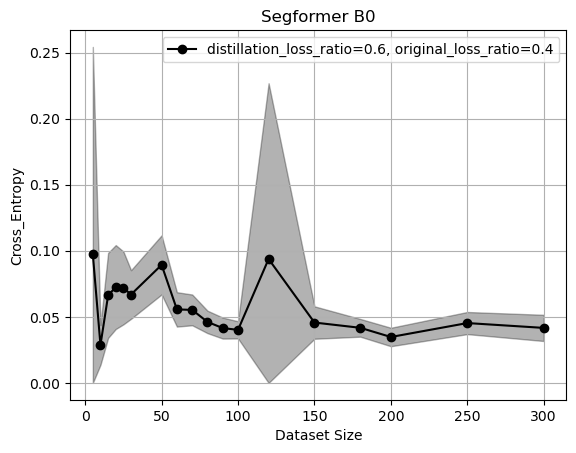

In [2]:
import os
import json

print("train_size size = ", np.array(train_sizes).size)
print("mean_val_losses size = ", np.array(mean_val_losses).size)
print("std_val_losses size = ", np.array(std_val_losses).size)
print("train_size = ", train_sizes)
print("mean_val_losses = ", mean_val_losses)
print("std_val_losses = ", std_val_losses)

results_dir = os.path.join(os.getcwd(), 'TrainingRecords', 'results_KD_segformer_0604')
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

results = {
    "train_sizes": train_sizes,
    "mean_val_losses": mean_val_losses,
    "std_val_losses": std_val_losses
}
json_path = os.path.join(results_dir, f"results_KD_segformer_0604_{int(teacher_ratio*100)}.json")
with open(json_path, 'w') as json_file:
    json.dump(results, json_file, indent=4)

plt.figure()
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label=f'distillation_loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 2)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title('Segformer B0')
plt.xlabel('Dataset Size')
plt.ylabel('Cross_Entropy')
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(results_dir, f"results_KD_segformer_0604_{int(teacher_ratio*100)}.png"))

plt.show()